In [16]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import requests
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import hvplot.pandas
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Import SKLearn Library and Classes
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [17]:
#set path to Features CSV and read in CSV
amd_df = pd.read_pickle('Resources/amd_features_df.pickle')
amd_df.tail()

,AMD Close,AMD Volume,Call Volume,Put Volume,Total Option Volume,Percent of Put,Put signals,Percent of calls,Call signals,bollinger_mid_band,...,bollinger_long,bollinger_short,bollinger_signal,rvol,rvol SD,rvol signal,Option rVol,Option rVol SD,Option rVol signal,daily returns
2019-12-23,45.47,52586935,264480.0,131907.0,396387.0,0.332773,False,0.667227,True,40.7662,...,0.0,-1.0,-1.0,1.267045,1.014151,1.0,1.471474,1.014151,1.0,0.029665
2019-12-24,46.53,42418841,279346.0,128062.0,407408.0,0.314334,False,0.685666,True,41.1027,...,0.0,-1.0,-1.0,1.024291,1.027352,0.0,1.477695,1.027352,0.0,0.023312
2019-12-26,46.64,55021416,344651.0,178378.0,523029.0,0.341048,False,0.658952,True,41.4862,...,0.0,-1.0,-1.0,1.306320,1.063301,1.0,1.801463,1.063301,1.0,0.002364
2019-12-27,46.18,35145491,191984.0,104085.0,296069.0,0.351557,False,0.648443,True,41.8247,...,0.0,-1.0,-1.0,0.831136,1.073322,0.0,0.998239,1.073322,0.0,-0.009863
2019-12-30,45.52,40046758,159600.0,96101.0,255701.0,0.375833,False,0.624167,True,42.1437,...,0.0,-1.0,-1.0,0.921420,1.090216,0.0,0.848911,1.090216,0.0,-0.014292


In [18]:
#Create new trading signals Df, 
trading_signals_df = pd.DataFrame()

In [19]:
#create features only dataframe by shifting feature signal, select features as x_var_list (for selling OTM puts, bollinger = bollinger short)

x_var_list = ['bollinger_short', 'rvol signal', 'Option rVol signal']

trading_signals_df[x_var_list] = amd_df[x_var_list].shift(1)

trading_signals_df = trading_signals_df.set_index(pd.to_datetime(amd_df.index, infer_datetime_format=True))
trading_signals_df.head()

,bollinger_short,rvol signal,Option rVol signal
2019-08-02,NaN,NaN,NaN
2019-08-05,0.0,0.0,0.0
2019-08-06,0.0,1.0,1.0
2019-08-07,0.0,0.0,0.0
2019-08-08,0.0,0.0,0.0


In [20]:
#add dependent variable for targeting a positive return, shift forward looking window by user defined amount
shift = 7
threshold = 0
trading_signals_df['Positive Return'] = np.where(amd_df['daily returns'].shift(-shift)> threshold, 1, 0)

In [21]:
#drop Na and reduce df by shift amount
trading_signals_df = trading_signals_df.dropna()
trading_signals_df = trading_signals_df[:-shift]
trading_signals_df.tail()

,bollinger_short,rvol signal,Option rVol signal,Positive Return
2019-12-12,0.0,0.0,0.0,1
2019-12-13,-1.0,1.0,1.0,1
2019-12-16,-1.0,1.0,1.0,1
2019-12-17,-1.0,0.0,0.0,0
2019-12-18,-1.0,0.0,0.0,0


In [22]:
# Manually splitting the data
split = int(0.7 * len(trading_signals_df))

X_train = trading_signals_df.iloc[: split, :-1]
X_test = trading_signals_df.iloc[split:, :-1]

y_train = trading_signals_df['Positive Return'][:split]
y_test = trading_signals_df['Positive Return'][split:]


In [23]:
#Train Random Forest Model
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

In [25]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["RF Predicted Value"] = predictions
Results['Forward Daily Returns'] = amd_df['daily returns'].shift(-shift)
Results

,Positive Return,RF Predicted Value,Forward Daily Returns
2019-11-12,0,1,-0.035863
2019-11-13,0,1,-0.009131
2019-11-14,1,1,0.016863
2019-11-15,0,1,-0.020854
2019-11-18,1,1,0.011291
2019-11-19,0,1,-0.006851
2019-11-20,0,1,-0.010475
2019-11-21,1,1,0.003958
2019-11-22,1,1,0.020747
2019-11-25,0,0,-0.001764


In [26]:
Results['RF Predicted Value'].to_pickle(r'C:\Users\Kiel\Desktop\FINTECH\UCB_fintech_homework\project_2 - local\Resources\RF_signals_df.pickle')

<AxesSubplot:>

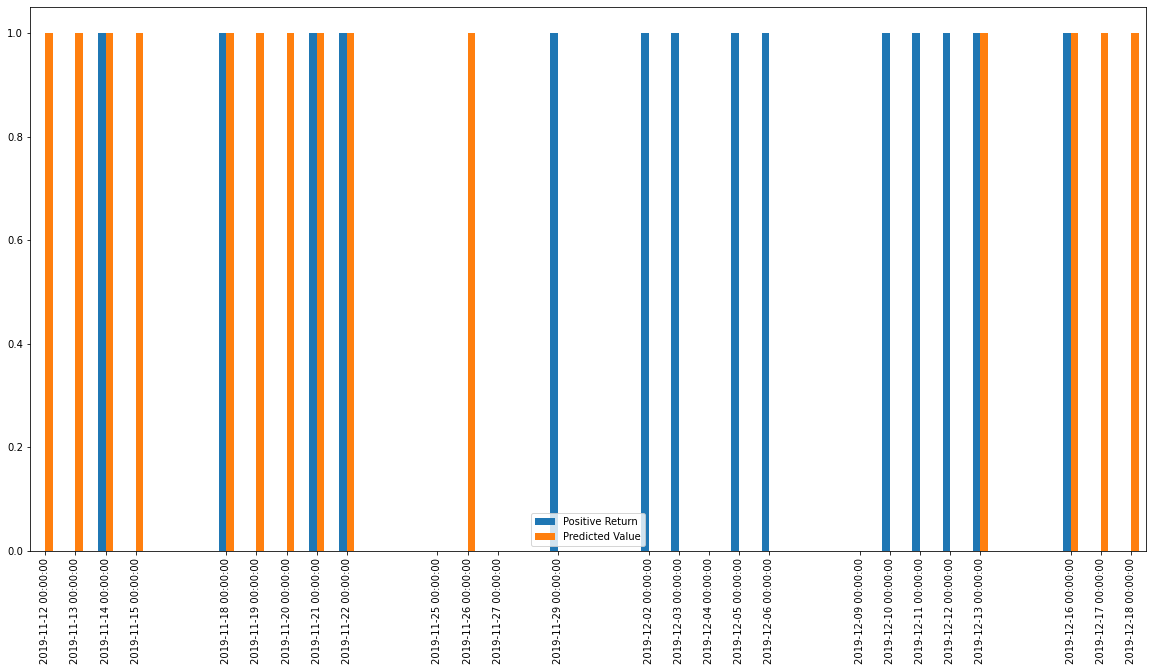

In [12]:
Results[['Positive Return', 'Predicted Value']].plot(figsize=(20,10), kind = 'bar')

In [13]:
Results['Positive Return'].sum()

14

<AxesSubplot:>

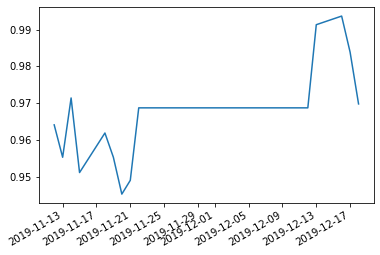

In [14]:
# Calculate cumulative return of model and plot the result
(1 + (Results['Forward Daily Returns'] * Results['Predicted Value'])).cumprod().plot()

<AxesSubplot:>

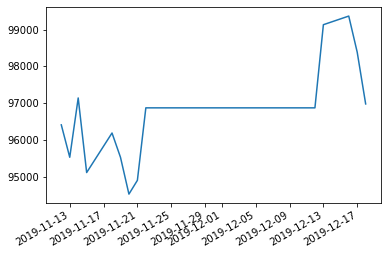

In [15]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (Results['Forward Daily Returns'] * Results['Predicted Value'])).cumprod()
cumulative_return_capital.plot()